Import dependancies

In [14]:
import tensorflow as tf
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator      #For rescale images
from tensorflow.python.keras.models import Sequential, Model
from __future__ import division, absolute_import, print_function, unicode_literals
from tensorflow.keras.utils import Sequence


# Make sure tenserflow version is above 2.0
try:
  %tensorflow_version 2.x
except Exvception:
  pass

Checking tensorflow version

In [2]:
tf.__version__

'2.2.0'

Download the flower dataset and unzip it

In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, fname="flower_photos.tgz", extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 4s 0us/step


In [5]:
img_size=224      #Image_height and image_size setting to this value
batch_size =64    #Batch size - Size of batches of data

1.   Rescale images using ImageDataGenerator()
2.   Create the train data generator and the validation data generator

In [6]:
#  Rescaling images to same using ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Train data generator

train_gen = datagen.flow_from_directory(
    base_dir,     #train dataset directory
    target_size = (img_size,img_size),      #image size (setting height and width)
    batch_size=batch_size,      #size of batches of data
    subset='training'     #subset of data (training)
)

# Validation data generator
  # same procedure as train data generator

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size = (img_size,img_size),
    batch_size=batch_size,
    subset='validation'     #subset of data (validation)
)


Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [7]:
# extracting labels and image features from train data 
for image_batch , label_batch in train_gen:
  break
  
print('Shepe of the image batch : ')
print(image_batch.shape)
print('Shepe of the label batch : ')
print(label_batch.shape)

Shepe of the image batch : 
(64, 224, 224, 3)
Shepe of the label batch : 
(64, 5)


In [8]:
print(train_gen.class_indices)      #checking class indices of train data

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [9]:
# saving the labels to a file, for later usage
labels = "\n".join(sorted(train_gen.class_indices.keys()))
with open('labels.txt','w') as f:
  f.write(labels)

In [10]:
!cat labels.txt     #view extracted labels in labels.txt

daisy
dandelion
roses
sunflowers
tulips

# Creating the base model with convnets

For creating the base model we have used MobileNet V2 model from google. also used pre-trained dataset "ImageNet"

Proforming "Feature Extraction"

Base layaer will be our immidiate layer for feature extraction
First, pick which intermediate layer of MobileNet V2 will be used for feature extraction. 

Excluding the top layer, classification layer is ideal.


In [11]:
IMG_SHAPE = (img_size, img_size, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,      #excluding the classificaton layer
                                              weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


# Feature extraction

Freeze the conv base created as base_model to use it as the feature extractor.
Then add classifer on top of it and train 

In [12]:
base_model.trainable = False

In [13]:
# Adding Classifrcation head
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32,3, activation ='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation = 'softmax')
])

# Compile the model

Compiling model before training.

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',      # loss function (because of many classes we have we used cateforical_crossentropy)
              metrics=['accuracy'])       # asking for accuracy metrix

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# see how many features have been extraced
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

# Training the model

In [20]:
epochs = 10     #number of epoches to train model

history = model.fit_generator(train_gen,      #generator
                              epochs=epochs,      #number of epoches as defined before
                              validation_data=val_gen,       #validation data
                              validation_steps=len(val_gen))      #number of validation steps to perform 

Epoch 1/10
46/46 [==============================] - 136s 3s/step - loss: 0.3201 - accuracy: 0.8942 - val_loss: 0.4123 - val_accuracy: 0.8577
Epoch 2/10
46/46 [==============================] - 133s 3s/step - loss: 0.1964 - accuracy: 0.9347 - val_loss: 0.4212 - val_accuracy: 0.8659
Epoch 3/10
46/46 [==============================] - 133s 3s/step - loss: 0.1345 - accuracy: 0.9602 - val_loss: 0.4346 - val_accuracy: 0.8577
Epoch 4/10
46/46 [==============================] - 131s 3s/step - loss: 0.0925 - accuracy: 0.9745 - val_loss: 0.5174 - val_accuracy: 0.8263
Epoch 5/10
46/46 [==============================] - 131s 3s/step - loss: 0.0699 - accuracy: 0.9816 - val_loss: 0.4742 - val_accuracy: 0.8673
Epoch 6/10
46/46 [==============================] - 136s 3s/step - loss: 0.0515 - accuracy: 0.9884 - val_loss: 0.5052 - val_accuracy: 0.8591
Epoch 7/10
46/46 [==============================] - 131s 3s/step - loss: 0.0304 - accuracy: 0.9963 - val_loss: 0.5218 - val_accuracy: 0.8564
Epoch 8/10
46

# Learning Curve

Learning curves of train and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor

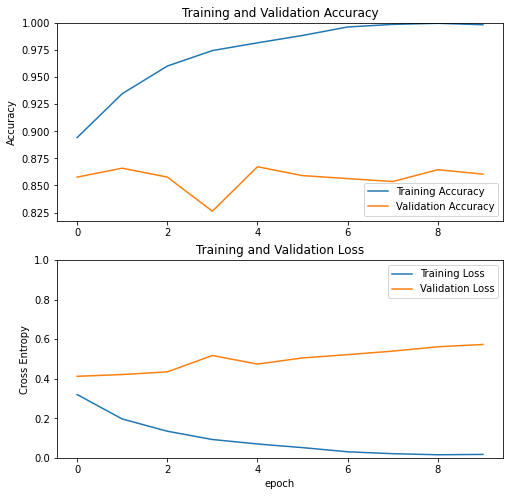

In [21]:
acc = history.history['accuracy']     #accuracy when training
val_acc = history.history['val_accuracy']       #accuracy when validating

loss = history.history['loss']        #loss when training
val_loss = history.history['val_loss']        #loss when  validating

# uses matplotlib to plot the lerning curves

# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

As for now we only uses few layers on top of our base_model, which is a MobileNet V2 base model. We had freezed the base_model in our conv model when we train the model before. Because of that weights of pre-trained network were not updated during training.

To increase performance of our model we can train the weights of teh layers of the pre-trained model alongside the training classifiers that we have added. This will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

For that we have to un-freeze the base_model, so we can use that to fine tune our model further.

In [22]:
base_model.trainable = True

In [23]:
# looking at how many layers are in base model
print('Number of layers in the base model : ', len(base_model.layers))

Number of layers in the base model :  155


In [25]:
# Fine tuning the model
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Compile again, modified model

In [26]:
# compile the modified model
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [27]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


In [28]:
# see how many features has been extracted
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


Train the modified model with the new extracted features

In [29]:
history_fine_tune =model.fit_generator(
    train_gen,
    epochs=5,
    validation_data = val_gen,
    validation_steps=len(val_gen)
)

Epoch 1/5
46/46 [==============================] - 221s 5s/step - loss: 0.4978 - accuracy: 0.8462 - val_loss: 0.5671 - val_accuracy: 0.8687
Epoch 2/5
46/46 [==============================] - 221s 5s/step - loss: 0.2281 - accuracy: 0.9139 - val_loss: 0.5590 - val_accuracy: 0.8741
Epoch 3/5
46/46 [==============================] - 226s 5s/step - loss: 0.1568 - accuracy: 0.9445 - val_loss: 0.5606 - val_accuracy: 0.8755
Epoch 4/5
46/46 [==============================] - 220s 5s/step - loss: 0.1021 - accuracy: 0.9643 - val_loss: 0.5644 - val_accuracy: 0.8728
Epoch 5/5
46/46 [==============================] - 225s 5s/step - loss: 0.0782 - accuracy: 0.9758 - val_loss: 0.5631 - val_accuracy: 0.8714


# Convert to TFLite

Convert our model to TFLite conpatible format.
TFLite inference refers to the process of executing a TensorFlow Lite model on-device in order to make predictions based on input data. (It can perform an inference using java, C++ Python to links other resources for each supported platform)

In [30]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model,saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite','wb') as f:
  f.write(tflite_model)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


# Download the converted model and labels

In [31]:
#Downloading the converted model and labels, to use in devices with tensorflow intergration
from google.colab import files

files.download('model.tflite')      # download model
files.download('labels.txt')        # download labels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Check learning curve



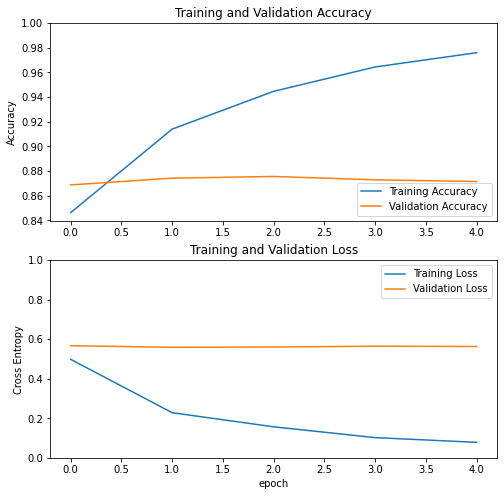

In [32]:
acc = history_fine_tune.history['accuracy']
val_acc = history_fine_tune.history['val_accuracy']

loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [34]:
print("Model is completed !")

Model is completed !
